<a href="https://colab.research.google.com/github/fellowship/platform-demos3/blob/master/InteriorDesignClassification/Multi_Label_Interior_Design_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries and Dataset

In [0]:
# Notebook magic commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#mount google drive in case we need to store data or transfer files
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# copy the csv file for labels and the dataset folder
import os
os.mkdir('data/')
!cp "drive/My Drive/fellowship/final_data.csv" "data/data.csv"
!cp "drive/My Drive/fellowship/interior_data.tar" "data/"

In [0]:
# Untar the tar file
!tar -zxf data/interior_data.tar -C data/

In [0]:
# Remove the tar file
!rm -rf data/*.tar

In [0]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [6]:
from pathlib import Path
path = Path('data')
imagepath = Path('data/train_images')
dataset = get_image_files(imagepath)
print(len(dataset))

20097


In [7]:
df = pd.read_csv(path/'data.csv')
df.head()

,images,class
0,img0.jpg,Classic Traditional
1,img1.jpg,Modern Bohemian Glam
2,img2.jpg,Modern Bohemian Glam
3,img3.jpg,Farmhouse Transitional
4,img4.jpg,Transitional


## Data Block API and Transfer Learning

In [0]:
tfms = get_transforms(max_warp=0., max_rotate=0)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'data.csv', folder='train_images')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=224)
        .databunch(bs=64).normalize(imagenet_stats))

In [11]:
data.classes

['Bohemian',
 'Classic',
 'Coastal',
 'Eclectic',
 'Farmhouse',
 'Glam',
 'Global',
 'Industrial',
 'Midcentury',
 'Minimal',
 'Modern',
 'Preppy',
 'Rustic',
 'Scandinavian',
 'Traditional',
 'Transitional']

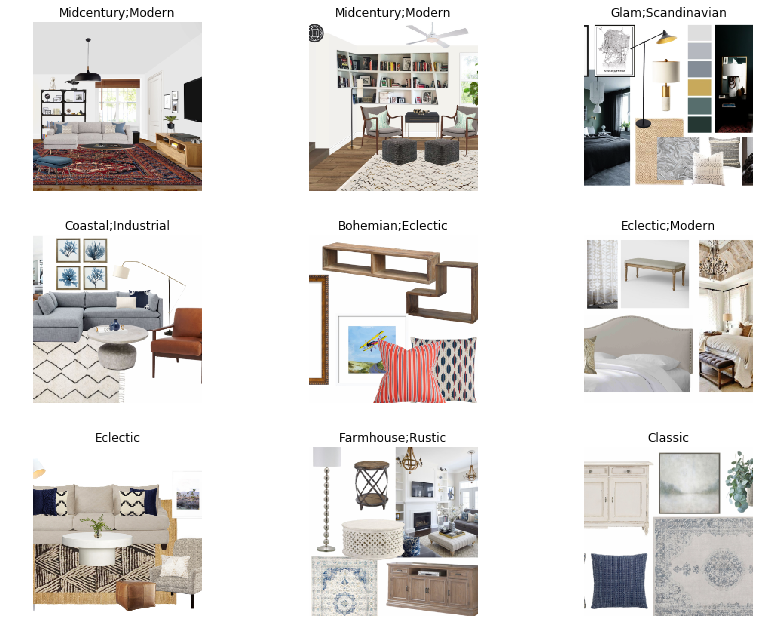

In [12]:
data.show_batch(rows=3, figsize=(12,9))

In [13]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
#f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, models.resnet34, metrics=acc_02)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 21857898.33it/s]


## Model Training

### Stage 1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02


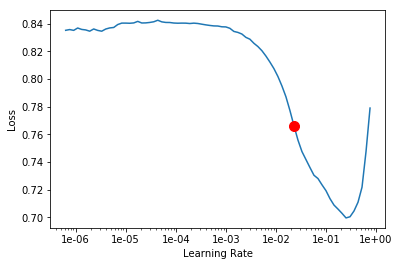

In [14]:
# Freeze the model and plot the Loss- Lr curve
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.347621,0.325100,0.798877,47:29
1,0.321876,0.313995,0.798924,48:35
2,0.311499,0.315300,0.812624,48:39
3,0.299158,0.294975,0.808286,48:22
4,0.292732,0.291350,0.816061,48:20


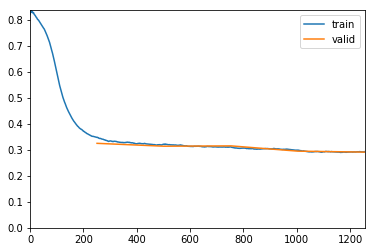

Better model found at epoch 0 with accuracy_thresh value: 0.7988771796226501.
Better model found at epoch 1 with accuracy_thresh value: 0.7989238500595093.
Better model found at epoch 2 with accuracy_thresh value: 0.8126243948936462.
Better model found at epoch 4 with accuracy_thresh value: 0.8160611987113953.


In [15]:
# Training the model for 5 epochs
learn.fit_one_cycle(5, max_lr=1e-02, callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='accuracy_thresh', name='Stage1-1')])

In [0]:
!cp 'data/models/Stage1-1.pth' 'drive/My Drive/fellowship/'

### Stage 1 Finetuning

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06


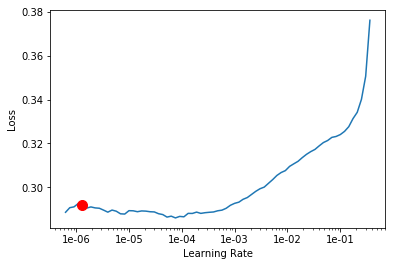

In [17]:
learn = learn.load('Stage1-1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.286470,0.290890,0.813962,49:10
1,0.282564,0.286111,0.820276,49:03
2,0.275964,0.283540,0.821582,48:59
3,0.272434,0.281414,0.826247,48:16
4,0.264176,0.281050,0.825967,49:24


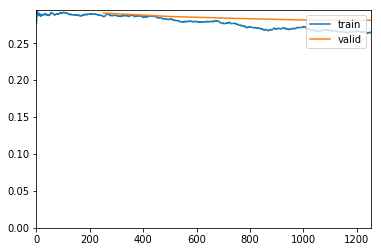

Better model found at epoch 0 with accuracy_thresh value: 0.8139618039131165.
Better model found at epoch 1 with accuracy_thresh value: 0.8202755451202393.
Better model found at epoch 2 with accuracy_thresh value: 0.8215818405151367.
Better model found at epoch 3 with accuracy_thresh value: 0.8262472152709961.


In [18]:
# Training the model for 5 epochs
learn.fit_one_cycle(5, max_lr=slice(1e-05,1e-04), callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='accuracy_thresh', name='Stage1-2')])

In [0]:
!cp 'data/models/Stage1-2.pth' 'drive/My Drive/fellowship/'

In [0]:
learn = learn.load('Stage1-2')
learn.export()
!cp 'data/export.pkl' 'drive/My Drive/fellowship/stage1.pkl'

## Interpolation

In [0]:
learn = learn.load('Stage1-2')

In [0]:
interp = ClassificationInterpretation.from_learner(learn, tta=True)

1748 misclassified samples over 4019 samples in the validation set.


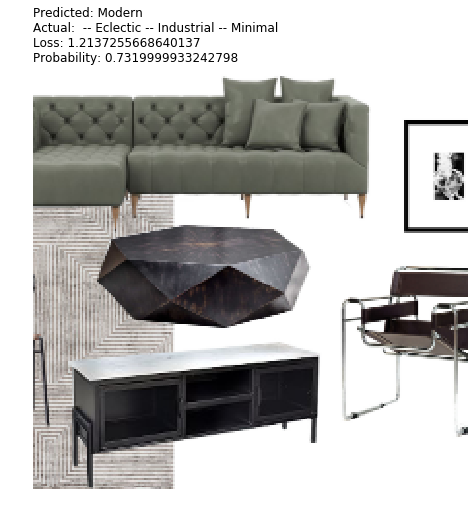

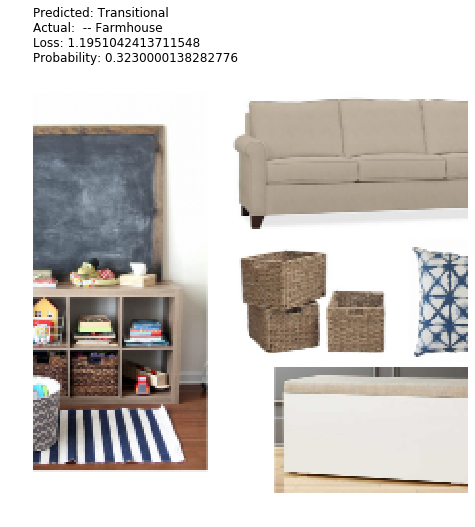

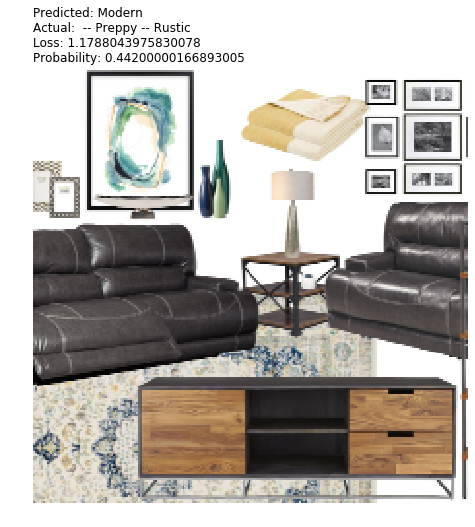

In [34]:
interp.plot_multi_top_losses()

## Predictions

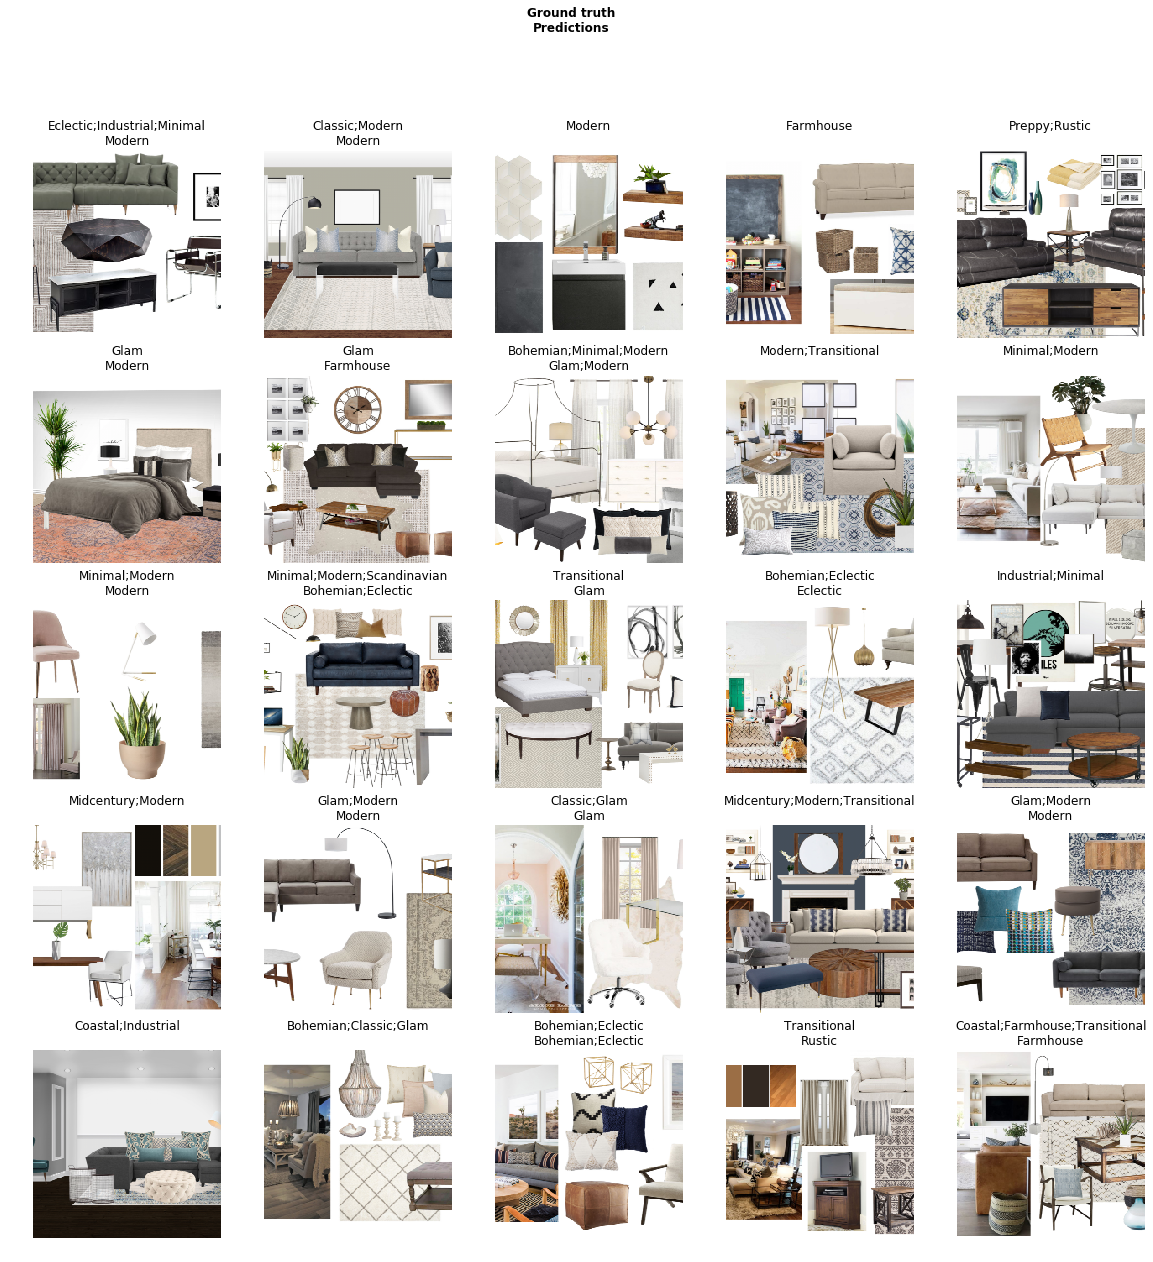

In [23]:
learn.show_results()

### Prediction on Test images

First two test images are from dataframe which had no labels. Third test image is taken randomly from websearch.



In [0]:
!cp 'drive/My Drive/fellowship/test1.jpg' 'data/'
!cp 'drive/My Drive/fellowship/test2.jpg' 'data/'
!cp 'drive/My Drive/fellowship/test3.jpg' 'data/'

Predicted Labels:  Modern;Transitional


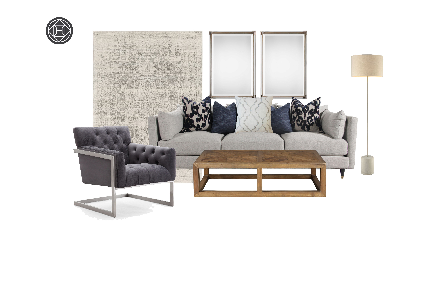

In [31]:
img1 = open_image('data/test1.jpg')
prediction = learn.predict(img1, thresh=0.2)
print("Predicted Labels: ",prediction[0])
img1.show(figsize=(7,7))

Predicted Labels:  Bohemian;Midcentury;Modern;Scandinavian


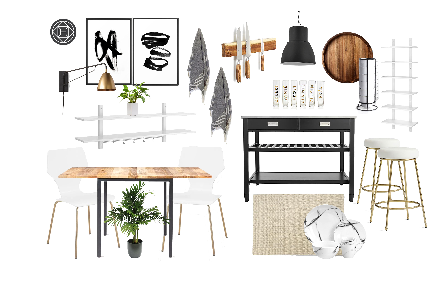

In [32]:
img2 = open_image('data/test2.jpg')
prediction = learn.predict(img2, thresh=0.2)
print("Predicted Labels: ",prediction[0])
img2.show(figsize=(7,7))

Predicted Labels:  Classic;Glam;Transitional


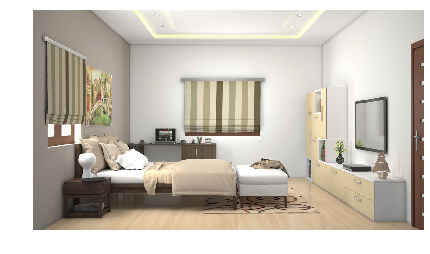

In [33]:
img3 = open_image('data/test3.jpg')
prediction = learn.predict(img3, thresh=0.2)
print("Predicted Labels: ",prediction[0])
img3.show(figsize=(7,7))

## Model Training Stage 2

In [0]:
tfms = get_transforms()

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'data.csv', folder='train_images')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=512)
        .databunch(bs=64).normalize(imagenet_stats))

In [0]:
!cp 'drive/My Drive/fellowship/Stage1-2.pth' 'data/models/'

In [0]:
learn = learn.load('Stage1-2')
learn.data = data
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
# Training the model for 5 epochs
learn.fit_one_cycle(5, max_lr=1e-02, callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='accuracy_thresh', name='stage2-1')])

In [0]:
learn = learn.load('Stage2-1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
# Training the model for 5 epochs
learn.fit_one_cycle(5, max_lr=slice(1e-06,1e-05), callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='accuracy_thresh', name='stage2-2')])

In [0]:
learn = learn.load('Stage2-2')

In [0]:
learn.export()